# SusieR benchmark plot


This is mostly the same as `20180516_SusieR_Benchmark_Plot.ipynb` but using `lm_less` simulation model instead of `simple_lm`. The difference is that now PVE is confined to 0.2. 

In [7]:
%revisions -n 10 --source

In [8]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

Other differences include:

1. Increase number of genes to 100 and use 2 replicates per analysis
2. Fix a minor bug in residual variance simulation
3. Use $|r|$ for LD filtering, not $r^2$
4. **Add histogram of purity**

Therefore I chose an LD cutoff of 0.5 for now (comparable to 0.25 when squared). But we argue that in practice it does not matter.

## Results

### Purity plots

Purity plots updated to [here](http://shiny.stephenslab.uchicago.edu/gaow/purity_20180620).

### Purity filter vs capture rate

> susie_comparison/ld_20180620.png (93.0 KiB):

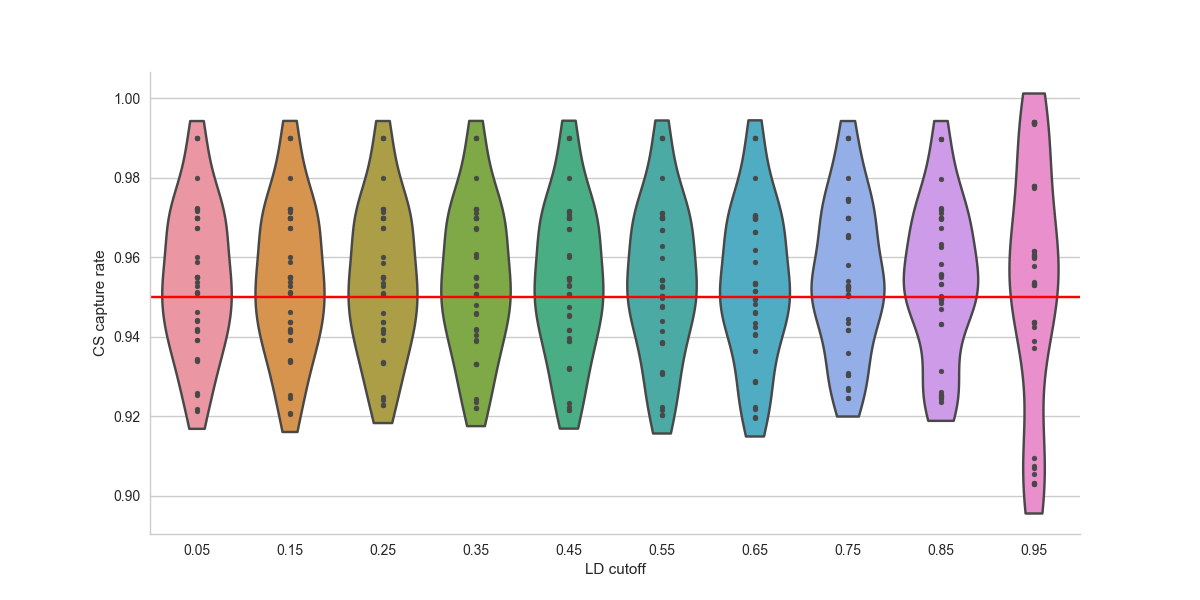

In [9]:
%preview susie_comparison/ld_20180620.png

## Run benchmark

In [ ]:
dsc susie.dsc --target susie_comparison

In [ ]:
[global]
parameter: outdir = path('./susie_comparison')
parameter: name = '20180620'
ld_cutoff = 0.2
lfsr_cutoff = 0.05

## Plot by purity

In [ ]:
[purity_1, ld_1]
target = "liter_data.dataset lm_less.pve lm_less.n_signal fit_susie.maxL fit_susie.estimate_residual_variance fit_susie.prior_var fit_susie plot_susie"
output: f'{outdir}/purity_{name}/result.RDS'
R: expand = '${ }'
    out = dscrutils::dscquery(${outdir:br}, target = "${target}", load.pkl = TRUE)
    saveRDS(out, ${_output:r})

In [ ]:
[purity_2, ld_2]
pve = [0.2]
n = [1,2,3,4,5]
est_res = ['TRUE', 'FALSE']
prior = [0.05, 0.1, 0.2, 0.4]
ld_col = 1 # LD_Min
combos = len(pve) * len(n) * len(est_res) * len(prior)
output_files = [f'{_input:d}/{x+1}.rds' for x in range(combos)]
input: for_each = ['pve', 'n', 'est_res', 'prior'], concurrent = True
output: output_files[_index]
R: expand = '${ }'

    get_combined = function(sub, dirname, ld_col) {
        out_files = sub[,c("fit_susie.output.file", "plot_susie.output.file")]
        combined = list(purity = NULL, lfsr = NULL, size = NULL, 
                        captures = NULL, total_captures = NULL, pip = NULL)
        for (i in 1:nrow(out_files)) {
            fit = readRDS(paste0(dirname, out_files[i,1], '.rds'))$posterior
            purity = readRDS(paste0(dirname, out_files[i,2], '.rds'))
            L = sub[i,"lm_less.n_signal"]
            for (r in 1:2) {
                #
                if (is.null(combined$purity)) combined$purity = purity$purity[[paste0('V',r)]][,ld_col]
                else combined$purity = cbind(combined$purity, purity$purity[[paste0('V',r)]][,ld_col])
                #
                if (is.null(combined$size)) combined$size = fit$n_in_CI[,r]
                else combined$size = cbind(combined$size, fit$n_in_CI[,r])
                #
                if (is.null(combined$lfsr)) combined$lfsr = fit$lfsr[,r]
                else combined$lfsr = cbind(combined$lfsr, fit$lfsr[,r])
                #
                if (is.null(combined$captures)) combined$captures = rowSums(purity$signal$V1)
                else combined$captures = cbind(combined$captures, rowSums(purity$signal$V1))
                #
                is_pure = which(purity$purity[[paste0('V',r)]][,ld_col] > ${ld_cutoff})
                alpha = fit$alpha[[r]][is_pure,,drop=FALSE]
                if (dim(alpha)[1] == 0) {
                  pip = t(rep(0, dim(alpha)[2]))
                } else {
                  pip = t(1 - apply(1 - alpha, 2, prod))
                }
                if (is.null(combined$pip)) combined$pip = pip
                else combined$pip = cbind(combined$pip, pip)            
                #
                detected = apply(t(purity$signal[[paste0('V',r)]][is_pure,,drop=FALSE]), 1, sum)
                if (length(detected) < L) {
                  detected = c(detected, rep(0, L - length(detected)))
                }
                if (is.null(combined$total_captures)) combined$total_captures = detected
                else combined$total_captures = combined$total_captures + detected
            }
        }
        return(combined)
    }
    out = readRDS(${_input:r})
    sub = out[which(out$lm_less.pve == ${_pve} & out$lm_less.n_signal == ${_n} & out$fit_susie.estimate_residual_variance == ${_est_res} & out$fit_susie.prior_var == ${_prior}),]
    combined = get_combined(sub, "${outdir}/", ${ld_col})
    write(paste(${_pve}, ${_n}, ${_prior}, ${_est_res}, "${_output:n}.png", sep=','), file='${_output:n}.log')
    saveRDS(combined, ${_output:r})

In [ ]:
[purity_3, ld_3]
input: group_by = 1, concurrent = True
output: f"{_input:n}.pkl"
bash: expand = True
  dsc-io {_input} {_output}

In [ ]:
[purity_4]
input: group_by = 1, concurrent = True
output: f"{_input:n}.png"
python: expand = '${ }'
    import numpy as np
    import matplotlib.pyplot as plt
    COLORS = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF']
    color_mapper = np.vectorize(lambda x: dict([(i,j) for i,j in enumerate(COLORS)]).get(x))

    def plot_purity(data, output, lfsr_cutoff = 0.05, verbose = False):
        purity = np.array(data['purity'])
        lfsr = np.array(data['lfsr'])
        size = np.array(data['size'])
        capture = np.array(data['captures'])
        capture_summary = [f"Signal {idx+1} captured {int(item)}/{purity.shape[1]}" for idx, item in enumerate([data['total_captures']] if isinstance(data['total_captures'], np.int64) else data['total_captures'])]
        idx = 0
        plt.figure(figsize=(12, 8))
        L = purity.shape[0]
        cols = 3
        rows = L // cols + L % cols
        position = range(1,L + 1)
        insig = []
        for x, y, z, c in zip(size, purity, lfsr, capture):
            # exclude previously marked insignificant positions
            exclude = [i for i, item in enumerate(x) if (x[i], y[i]) in insig]
            z_sig = [i for i, zz in enumerate(z) if zz <= lfsr_cutoff and i not in exclude]
            z_nsig = [i for i, zz in enumerate(z) if zz > lfsr_cutoff and i not in exclude]
            colors = [4 if i == 0 else 0 for i in c]
            plt.subplot(rows,cols,position[idx])
            idx += 1
            if len(z_sig):
                label = f'L{idx}: lfsr<={lfsr_cutoff}'
                plt.scatter(np.take(x, z_sig),
                            np.take(y, z_sig),
                            c = color_mapper(np.take(colors, z_sig)), 
                            label = label, marker = '*')
            if len(z_nsig):
                label = f'L{idx}: lfsr>{lfsr_cutoff}'
                plt.scatter(np.take(x, z_nsig),
                            np.take(y, z_nsig),
                            c = color_mapper(np.take(colors, z_nsig)), 
                            label = label, marker = 'x')
            # mask colored (insig) sets
            insig.extend([(x[i], y[i]) for i, item in enumerate(colors) if item > 0 and i not in exclude])
            insig = list(set(insig))
            plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=2, handletextpad=0.1)
            plt.axhline(y=${ld_cutoff}, color = '#FF0000', alpha=0.5)
        plt.subplots_adjust(hspace=0.3, wspace = 0.3)
        if verbose:
            plt.suptitle(f"95% CI set sizes vs min(abs(LD)) | LD filter ${ld_cutoff}\n{'; '.join(capture_summary)}")
        plt.savefig(output, dpi=500, bbox_inches='tight') 
        plt.gca()

    import pickle
    data = pickle.load(open('${_input}', 'rb'))
    plot_purity(data, '${_output}', lfsr_cutoff = ${lfsr_cutoff})

[purity_5]
header = 'PVE,N_Causal,susie_prior,est_residual,output'
output:  f'{outdir}/purity_{name}/index.html'
bash: expand = True
    echo {header} > {_output:n}.csv
    cat {str(_input).replace('.png', '.log')} >> {_output:n}.csv
    cd {_output:d}
    dsc-io {_output:an}.csv {_output:a}

## Plot by LD

In [ ]:
[ld_4]
output: f'{outdir}/ld_{name}.pkl'
python: expand = '${ }'
    import numpy as np
    import pickle
    lds = dict([(x, []) for x in np.linspace(0, 1, num=21) if x < 1])
    for f in [${_input:r,}]:
        data = pickle.load(open(f, 'rb'))
        for k in lds:
            cs_capture_status = np.array(data['captures'][np.where(data['purity'] > k)]).ravel()
            if len(cs_capture_status):
                lds[k].append((f, sum(cs_capture_status > 0) / len(cs_capture_status)))
    with open(${_output:r}, 'wb') as f:
        pickle.dump(lds, f)

In [ ]:
[ld_5]
output: f'{_input:n}.png'
python: expand = '${ }'
    import pickle
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt
    sns.set(rc={'figure.figsize':(12,6)}, style = "whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))

    data = pickle.load(open('${outdir}/ld_${name}.pkl', 'rb'))
    plot_data = dict([('LD cutoff', []), ('CS capture rate', [])])
    idx = 0
    for k in sorted(data.keys()):
        idx += 1
        if idx % 2:
            continue
        for item in data[k]:
            plot_data['LD cutoff'].append(f'{k:.2f}')
            plot_data['CS capture rate'].append(item[1])
    plot_data = pd.DataFrame(plot_data)
    sns.violinplot(ax=ax, x="LD cutoff", y="CS capture rate", data=plot_data, cut=0.5, inner="points")
    sns.despine()
    plt.axhline(0.95, color='red')
    ax.get_figure().savefig(${_output:r})